In [1]:
import regression as r

In [2]:
icgem_data_gravity_ell = r.hm.load_icgem_gdf("data/data-0/gravity_ell_GOCO06s_b879cfa8a540bb2270679488088ac44ae6bb97a88e9a684d371b9bf791af0ae8.gdf")
icgem_data_topography_grd = r.hm.load_icgem_gdf("data/data-0/topography_grd_etopo1-2250_e7099801d365e5743ae72126f13202d19064ee81d61ff961a85b58f9ace75454.gdf")

In [3]:
icgem_data_topography_grd

<xarray.Dataset> Size: 527kB
Dimensions:         (latitude: 181, longitude: 361)
Coordinates:
  * latitude        (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude       (longitude) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    topography_grd  (latitude, longitude) float64 523kB 2.745e+03 ... -4.228e+03
Attributes: (12/27)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/02
    product_type:          topography
    body:                  earth
    modelname:             etopo1-2250
    functional:            topography_grd (grid)=>bi-linear interpolation
    ...                    ...
    maxvalue:              5.8550000E+03 meter
    minvalue:              -9.2000000E+03 meter
    signal_wrms:           2.5063751E+03 meter
    grid_format:           long_lat_value
    attributes:            longitude latitude topography_grd
    attributes_units:      deg. deg. meter

In [4]:
icgem_data_gravity_ell

<xarray.Dataset> Size: 1MB
Dimensions:          (latitude: 181, longitude: 361)
Coordinates:
  * latitude         (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude        (longitude) float64 3kB -180.0 -179.0 ... 179.0 180.0
Data variables:
    gravity_ell      (latitude, longitude) float64 523kB 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 523kB 1e+04 1e+04 ... 1e+04
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/02
    product_type:          gravity_field
    body:                  earth
    modelname:             GOCO06s
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.8015408E+05 mgal
    minvalue:              9.7486690E+05 mgal
    signal_wrms:           1.5471939E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [5]:
data = r.xr.merge(
    [icgem_data_gravity_ell.rename({"gravity_ell":"gravity"}), icgem_data_topography_grd.rename({"topography_grd":"topography"})
    ])

data

<xarray.Dataset> Size: 2MB
Dimensions:          (latitude: 181, longitude: 361)
Coordinates:
  * latitude         (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude        (longitude) float64 3kB -180.0 -179.0 ... 179.0 180.0
Data variables:
    gravity          (latitude, longitude) float64 523kB 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 523kB 1e+04 1e+04 ... 1e+04
    topography       (latitude, longitude) float64 523kB 2.745e+03 ... -4.228...
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/02
    product_type:          gravity_field
    body:                  earth
    modelname:             GOCO06s
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.8015408E+05 mgal
    minvalue:              9.7486690E+05 mgal
    signal_wrms:           1.5471939E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [6]:
# gravidade normal elipsoidal a 10km
gamma = r.bl.WGS84.normal_gravity(data.latitude, 10000)

disturbance = data.gravity - gamma

bouguer_corr = r.hm.bouguer_correction(data.topography)
data["dg_bouguer"] = disturbance - bouguer_corr

data

<xarray.Dataset> Size: 2MB
Dimensions:          (latitude: 181, longitude: 361)
Coordinates:
  * latitude         (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude        (longitude) float64 3kB -180.0 -179.0 ... 179.0 180.0
Data variables:
    gravity          (latitude, longitude) float64 523kB 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 523kB 1e+04 1e+04 ... 1e+04
    topography       (latitude, longitude) float64 523kB 2.745e+03 ... -4.228...
    dg_bouguer       (latitude, longitude) float64 523kB -340.8 -340.8 ... 298.8
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/02
    product_type:          gravity_field
    body:                  earth
    modelname:             GOCO06s
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.8015408E+05 mgal
    minvalue:              9.7486690E+05 mgal
    signal_wrms:           1.5471939E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [7]:
topo = data.topography.values.ravel()
dg = data.dg_bouguer.values.ravel()

mask = ~r.np.isnan(topo) & ~r.np.isnan(dg)
h = topo[mask]
d = dg[mask]

data

<xarray.Dataset> Size: 2MB
Dimensions:          (latitude: 181, longitude: 361)
Coordinates:
  * latitude         (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude        (longitude) float64 3kB -180.0 -179.0 ... 179.0 180.0
Data variables:
    gravity          (latitude, longitude) float64 523kB 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 523kB 1e+04 1e+04 ... 1e+04
    topography       (latitude, longitude) float64 523kB 2.745e+03 ... -4.228...
    dg_bouguer       (latitude, longitude) float64 523kB -340.8 -340.8 ... 298.8
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/02
    product_type:          gravity_field
    body:                  earth
    modelname:             GOCO06s
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.8015408E+05 mgal
    minvalue:              9.7486690E+05 mgal
    signal_wrms:           1.5471939E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [8]:
region = r.vd.get_region((data.longitude.values, data.latitude.values)) # usar .values para passar paena sos valores numéricos

lon_grid, lat_grid = r.vd.grid_coordinates(
    region = region,
    shape = data.topography.shape,
    meshgrid = True
)

lon_all = lon_grid.ravel()
lat_all = lat_grid.ravel()

mask = ~r.np.isnan(lon_all) & ~r.np.isnan(lat_all)
lon, lat = lon_all[mask], lat_all[mask]

In [9]:
window_coordinates, indices = r.bd.rolling_window_spherical(
    coordinates = (lon, lat),
    window_size = 3.0, # janelas de 3 graus
    overlap = 0
)

In [10]:
resultados = []
cont = 0

for i, idx_window in enumerate(indices):
    h_window = h[idx_window]
    
    if len(h_window) == 0:
        cont += 1
        print(f' Window {i} is empty. Coordinates: Lon {window_coordinates[0][i]:.2f}, Lat{window_coordinates[1][i]:.2f}')
        continue # vai para a próxima janela, próximo 'i'
    
    d_window = d[idx_window]
    p_window = r.robust_regression(h_window, d_window)

    n_points_ocean = r.np.sum(h_window < 0)
    n_points_continent = r.np.sum(h_window >=0)

    resultados.append({
        'original-idx': i,
        'longitude': window_coordinates[0][i],
        'latitude': window_coordinates[1][i],
        'a_o': p_window[0],
        'a_c':p_window[1],
        'b': p_window[2],
        'points':len(idx_window[0]),
        'ocean-points': n_points_ocean,
        'continent_points': n_points_continent
    })

print(f'Há {cont} janelas sem valores registrados de topografia.')

 Window 3 is empty. Coordinates: Lon -65.40, Lat-88.50
 Window 13 is empty. Coordinates: Lon -21.10, Lat-85.50
 Window 82 is empty. Coordinates: Lon -6.43, Lat-76.50
 Window 117 is empty. Coordinates: Lon -5.31, Lat-73.50
 Window 158 is empty. Coordinates: Lon -4.51, Lat-70.50
 Window 316 is empty. Coordinates: Lon -3.17, Lat-61.50
 Window 523 is empty. Coordinates: Lon -2.47, Lat-52.50
 Window 774 is empty. Coordinates: Lon -2.07, Lat-43.50
 Window 866 is empty. Coordinates: Lon -1.98, Lat-40.50
 Window 962 is empty. Coordinates: Lon -1.90, Lat-37.50
 Window 1165 is empty. Coordinates: Lon -1.77, Lat-31.50
 Window 1271 is empty. Coordinates: Lon -1.72, Lat-28.50
 Window 1380 is empty. Coordinates: Lon -1.67, Lat-25.50
 Window 1606 is empty. Coordinates: Lon -1.59, Lat-19.50
 Window 1722 is empty. Coordinates: Lon -1.57, Lat-16.50
 Window 3036 is empty. Coordinates: Lon -1.57, Lat16.50
 Window 3150 is empty. Coordinates: Lon -1.59, Lat19.50
 Window 3371 is empty. Coordinates: Lon -1.67

In [11]:
df_windows = r.pd.DataFrame(resultados)#.dropna(subset = ['a_o', 'a_c', 'b'])
df_windows.to_csv('df_windows.csv')
#df_windows

,original-idx,longitude,latitude,a_o,a_c,b,points,ocean-points,continent_points
0,0,57.302325,-88.5,NaN,-0.079103,-123.081589,460,0,460
1,1,180.000000,-88.5,NaN,-0.126493,22.701709,464,0,464
2,2,302.697675,-88.5,NaN,-0.135571,32.415590,456,0,456
3,4,19.118242,-85.5,NaN,-0.066595,-133.940247,156,0,156
4,5,59.338682,-85.5,NaN,-0.086981,-80.082762,152,0,152
...,...,...,...,...,...,...,...,...,...
4609,4637,300.661318,85.5,-0.066042,NaN,23.563020,152,152,0
4610,4638,340.881758,85.5,-0.065981,NaN,25.246801,152,152,0
4611,4640,57.302325,88.5,-0.054545,NaN,70.694437,460,460,0
4612,4641,180.000000,88.5,-0.068628,NaN,7.196106,464,464,0


In [12]:
df_windows_mixed_coefs = r.pd.DataFrame(resultados).dropna(subset = ['a_o', 'a_c', 'b'])
df_windows_mixed_coefs.to_csv('df_windows_mixed_coefs.csv')
#df_windows_mixed_coefs

,original-idx,longitude,latitude,a_o,a_c,b,points,ocean-points,continent_points
39,41,171.820529,-79.5,-0.066564,-0.104446,-32.685707,72,32,40
40,42,188.179471,-79.5,-0.060269,-0.207820,-37.550184,72,39,33
41,43,204.538413,-79.5,-0.068133,-0.106856,-40.939469,64,6,58
48,50,319.051009,-79.5,-0.069220,-0.103741,-24.552143,68,9,59
64,66,160.713943,-76.5,-0.065495,-0.111465,-39.708246,52,18,34
...,...,...,...,...,...,...,...,...,...
4597,4625,281.104832,82.5,-0.065834,-0.114564,24.197079,92,46,46
4598,4626,303.572573,82.5,-0.094620,-0.110936,3.402015,92,50,42
4599,4627,326.040313,82.5,-0.068003,-0.100467,25.040690,92,29,63
4600,4628,348.508054,82.5,-0.070239,-0.119111,21.679972,88,77,11


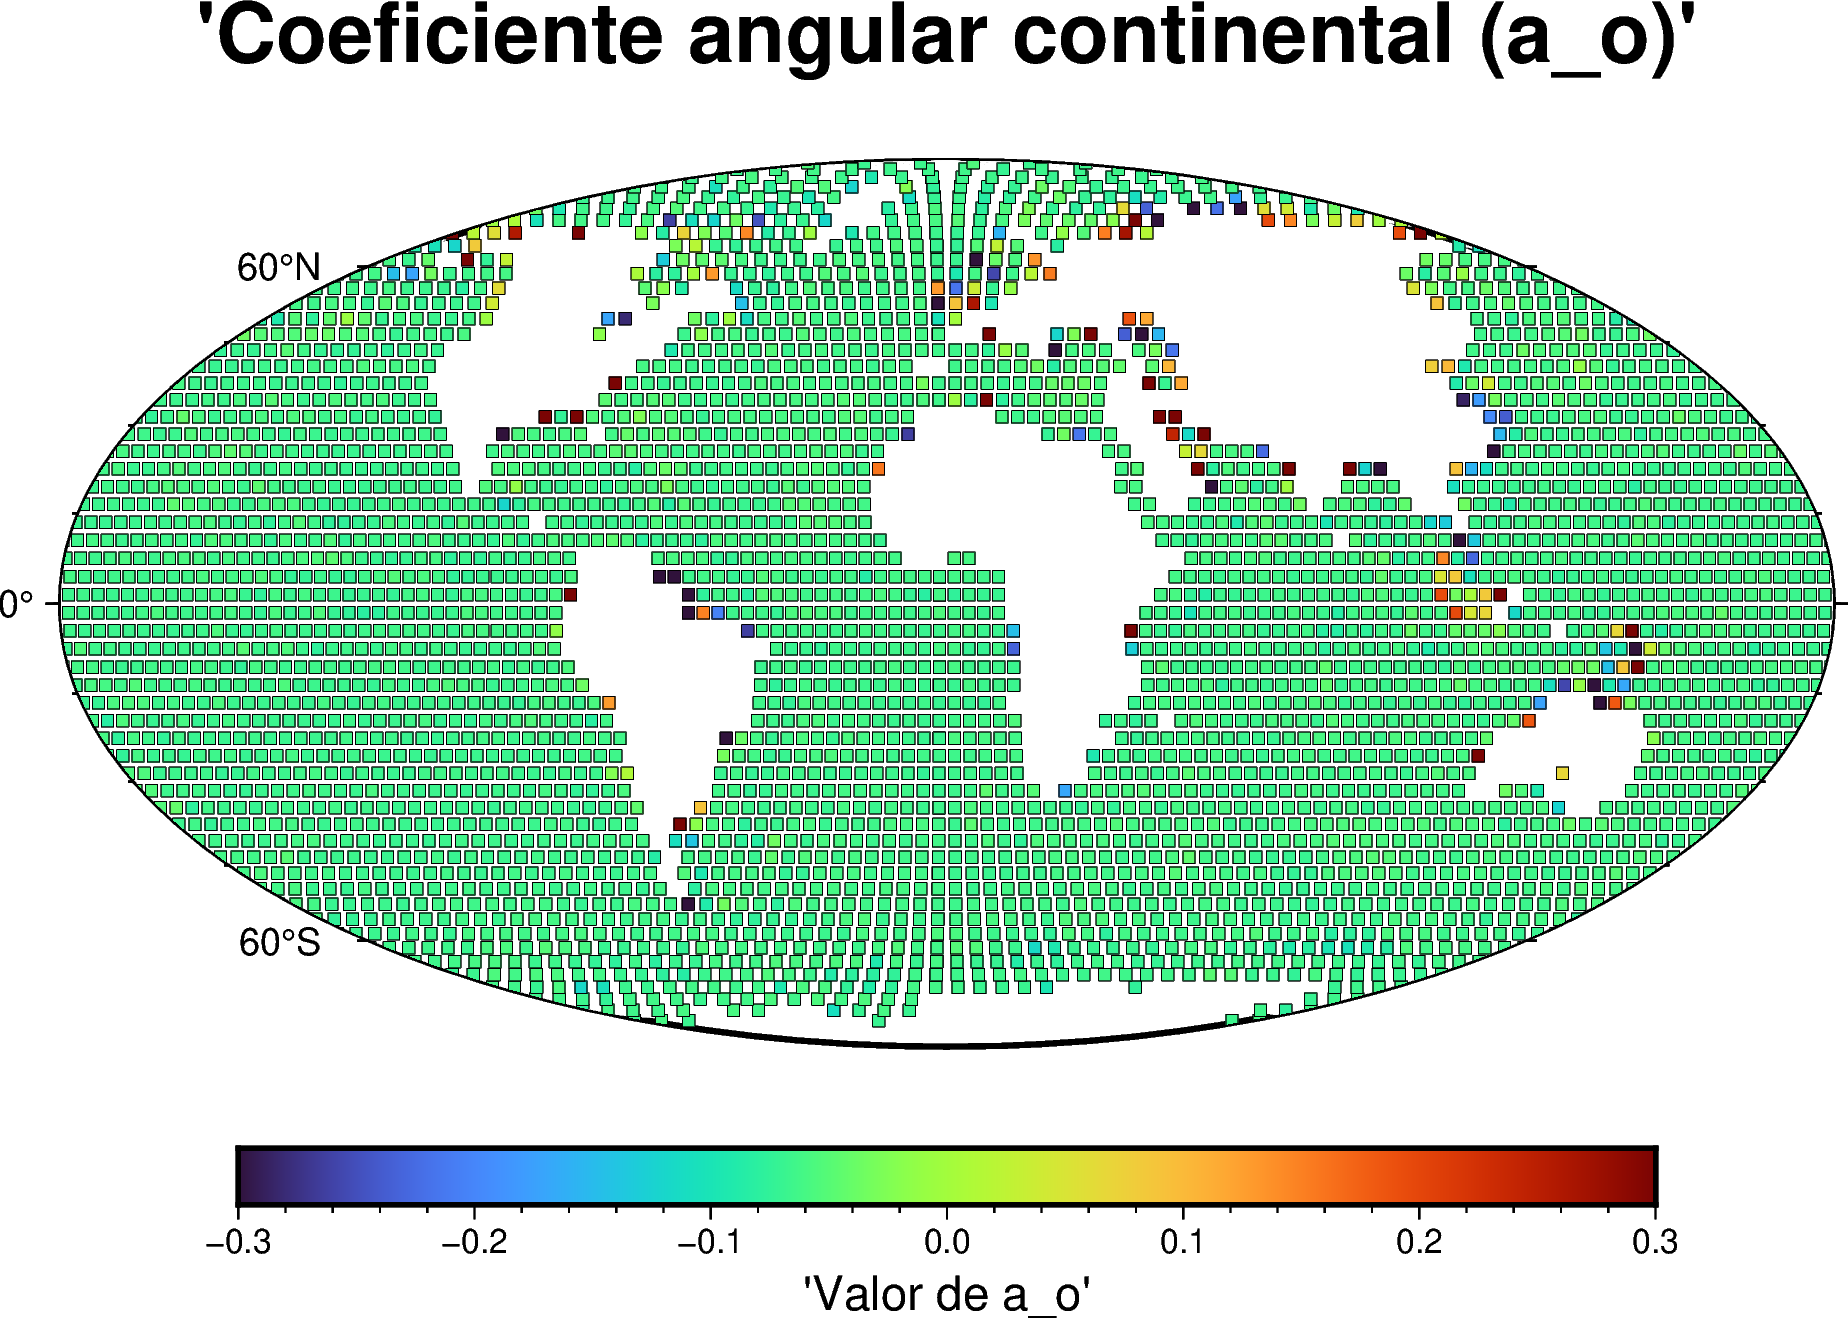

In [13]:
v_min = -0.3
v_max = 0.3
passo = 0.01 # Quanto menor o passo, mais suave a transição de cores

fig = r.pygmt.Figure()

# Criar a CPT com limites fixos
r.pygmt.makecpt(
    cmap='turbo', 
    series=[v_min, v_max, passo], 
    continuous=True,
    # Opcional: faz com que valores < -1 fiquem com a cor do mínimo 
    # e valores > 1 fiquem com a cor do máximo
    background=True 
)


fig.basemap(region = 'd', # 'd' = domain, global
            projection = 'W15c', # projeção de Robinson, mapa com 15cm, 'a': annotation, ativa coordenadas numéricas, 'f' de frame ticks, traços de régua
            frame = ["af", "WSne+t'Coeficiente angular continental (a_o)'"] # WSne refe explicitamente apenas W e S, os outros naão são escritos, +t é o título do mapa
           )

fig.coast(water = 'white') # shorelines = '1/0.5p,black', land = 'lightgray'


df_plot = df_windows.dropna(subset = ['a_o'])
fig.plot(
    x = df_plot.longitude,
    y = df_plot.latitude, 
    fill = df_plot.a_o, #montando um mapa, que é uma grade
    cmap = True,
    style = 's0.15c', # quero plotado quadrados de 0.25cm
    pen = '0.1p, black', # contorno do plot dos quadrados, nesse caso 
)

fig.colorbar(frame = "af+l'Valor de a_o'")

fig.savefig('mapa-coeficiente-continental.png', dpi = 300)

fig.show()

            

In [14]:
# janela especifica que quero acessar
i_wished_window = 167
line_in_df = df_windows.loc[df_windows['original-idx'] == i_wished_window] # localizo original-idx

if not line_in_df.empty: # para caso a linha não esteja no df 
    lon = line_in_df['longitude'].values[0] # [0] para o pandas não bugar, ele ve values como filtro
    lat = line_in_df['latitude'].values[0]

    print(f'A janela {i_wished_window} tem coordenadas: Longitude {lon:.2f} e Latitude {lat:.2f}')

else:
    print(f'A janela não está no df e pode ter sido descartada ou está vazia')

line_in_df

A janela 167 tem coordenadas: Longitude 66.53 e Latitude -67.50


,original-idx,longitude,latitude,a_o,a_c,b,points,ocean-points,continent_points
162,167,66.526022,-67.5,-0.065487,-0.100296,22.316212,32,17,15


In [15]:
idx_current = indices[i_wished_window][0]

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

# crio uma lista com os índices de h_window_raw que colocam o array em ordem numérica ex: [28, 3, 87] é o que deicaria o array em ordem
idx_sort = r.np.argsort(h_window_raw)

h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window)
a_ocean_window, a_continent_window, intercept_window = p_window

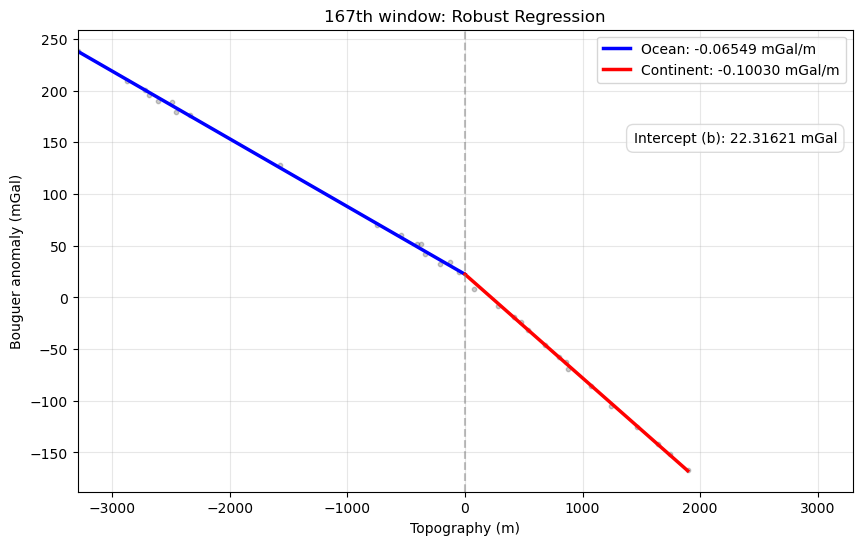

In [16]:
r.plot_window_regression(i_wished_window, h_window, d_window, a_ocean_window, a_continent_window, intercept_window)